# Overview

In [1]:
# import library
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

# Visualization Library
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# Machine Learning Model Library
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import Pool
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Evaluation Library
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

# others
from sklearn import base
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')
%precision 3

'%.3f'

In [2]:
# directory path
dir_path = '/kaggle/input/playground-series-s4e12/'

# read train.csv and test.csv
train_df = pd.read_csv(dir_path + 'train.csv')
test_df = pd.read_csv(dir_path + 'test.csv')

# connect train and test
df = pd.concat([train_df, test_df], ignore_index=True)

print(f'train data: {train_df.shape}')
print(f'test data: {test_df.shape}')
print(f'connect data: {df.shape}')

train data: (1200000, 21)
test data: (800000, 20)
connect data: (2000000, 21)


In [3]:
#data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Age                   float64
 2   Gender                object 
 3   Annual Income         float64
 4   Marital Status        object 
 5   Number of Dependents  float64
 6   Education Level       object 
 7   Occupation            object 
 8   Health Score          float64
 9   Location              object 
 10  Policy Type           object 
 11  Previous Claims       float64
 12  Vehicle Age           float64
 13  Credit Score          float64
 14  Insurance Duration    float64
 15  Policy Start Date     object 
 16  Customer Feedback     object 
 17  Smoking Status        object 
 18  Exercise Frequency    object 
 19  Property Type         object 
 20  Premium Amount        float64
dtypes: float64(9), int64(1), object(11)
memory usage: 320.4+ MB


In [4]:
# Convert Policy Start Date from object to datetime.
df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])

In [5]:
# Grouping columns of the same data type
number_columns = df.select_dtypes(include='float')
category_columns = df.select_dtypes(include='object')
datetime_columns = df.select_dtypes(include='datetime')

In [6]:
number_columns.head()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
0,19.0,10049.0,1.0,22.598761,2.0,17.0,372.0,5.0,2869.0
1,39.0,31678.0,3.0,15.569731,1.0,12.0,694.0,2.0,1483.0
2,23.0,25602.0,3.0,47.177549,1.0,14.0,NaN,3.0,567.0
3,21.0,141855.0,2.0,10.938144,1.0,0.0,367.0,1.0,765.0
4,21.0,39651.0,1.0,20.376094,0.0,8.0,598.0,4.0,2022.0


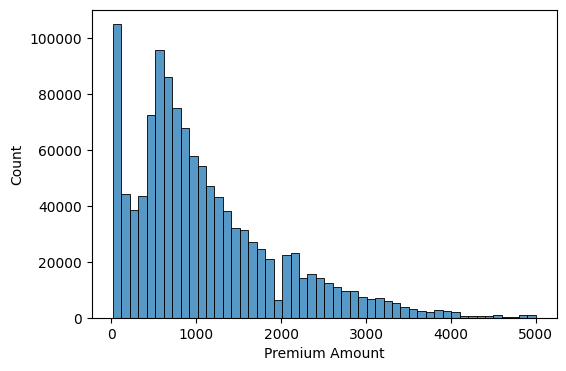

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(df['Premium Amount'], kde=False, bins=50)
plt.show()

In [8]:
category_columns.head()

,Gender,Marital Status,Education Level,Occupation,Location,Policy Type,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,Female,Married,Bachelor's,Self-Employed,Urban,Premium,Poor,No,Weekly,House
1,Female,Divorced,Master's,NaN,Rural,Comprehensive,Average,Yes,Monthly,House
2,Male,Divorced,High School,Self-Employed,Suburban,Premium,Good,Yes,Weekly,House
3,Male,Married,Bachelor's,NaN,Rural,Basic,Poor,Yes,Daily,Apartment
4,Male,Single,Bachelor's,Self-Employed,Rural,Premium,Poor,Yes,Weekly,House


In [9]:
datetime_columns.head()

,Policy Start Date
0,2023-12-23 15:21:39.134960
1,2023-06-12 15:21:39.111551
2,2023-09-30 15:21:39.221386
3,2024-06-12 15:21:39.226954
4,2021-12-01 15:21:39.252145


# Missing

In [10]:
df.isnull().sum()

id                           0
Age                      31194
Gender                       0
Annual Income            74809
Marital Status           30865
Number of Dependents    182802
Education Level              0
Occupation              597200
Health Score            123525
Location                     0
Policy Type                  0
Previous Claims         606831
Vehicle Age                  9
Credit Score            229333
Insurance Duration           3
Policy Start Date            0
Customer Feedback       130100
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount          800000
dtype: int64

Before filling in the missing values, a new feature is created with the data with missing values as 1 and the data without missing values as 0.

In [11]:
# create new features
df['Annual Income isnull'] = df.isnull()['Annual Income'].map({True: 1, False: 0})
df['Customer Feedback isnull'] = df.isnull()['Customer Feedback'].map({True: 1, False: 0})
df['Health Score isnull'] = df.isnull()['Health Score'].map({True: 1, False: 0})

Missing values in categorical columns are filled with Unknown.
Previous Claims are filled by 0, and other missing values are complemented by the median.

In [12]:
# category columns
for cat_col in category_columns:
  df[cat_col] = df[cat_col].fillna('Unknown')

In [13]:
# Previous Claims
df['Previous Claims'] = df['Previous Claims'].fillna(0)

# other numeric data
num_feature_columns = number_columns.drop('Premium Amount', axis=1)
for num_col in num_feature_columns:
  df[num_col] = df[num_col].fillna(df[num_col].median())

In [14]:
df.isnull().sum()

id                               0
Age                              0
Gender                           0
Annual Income                    0
Marital Status                   0
Number of Dependents             0
Education Level                  0
Occupation                       0
Health Score                     0
Location                         0
Policy Type                      0
Previous Claims                  0
Vehicle Age                      0
Credit Score                     0
Insurance Duration               0
Policy Start Date                0
Customer Feedback                0
Smoking Status                   0
Exercise Frequency               0
Property Type                    0
Premium Amount              800000
Annual Income isnull             0
Customer Feedback isnull         0
Health Score isnull              0
dtype: int64

# Preprocessing

In [15]:
# datetime
df['Policy Start Year'] = df['Policy Start Date'].dt.year
df['Policy Start Month'] = df['Policy Start Date'].dt.month
df['Policy Start Day'] = df['Policy Start Date'].dt.day

df = df.drop('Policy Start Date', axis=1)

In [16]:
df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Annual Income isnull,Customer Feedback isnull,Health Score isnull,Policy Start Year,Policy Start Month,Policy Start Day
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,No,Weekly,House,2869.0,0,0,0,2023,12,23
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,Unknown,15.569731,Rural,...,Yes,Monthly,House,1483.0,0,0,0,2023,6,12
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,Yes,Weekly,House,567.0,0,0,0,2023,9,30
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,Unknown,10.938144,Rural,...,Yes,Daily,Apartment,765.0,0,0,0,2024,6,12
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,Yes,Weekly,House,2022.0,0,0,0,2021,12,1


Train_data and test_data are used for regression models.

In [17]:
train_data = df[~df['Premium Amount'].isnull()]
test_data = df[df['Premium Amount'].isnull()]

Train_data2 and test_data2 are used for classification models.

In [18]:
train_data2 = train_data.copy()
train_data2['Premium Amount flg-500'] = train_data2['Premium Amount'].map(lambda x: 1 if x <= 500 else 0)

test_data2 = test_data.copy()
test_data2['Premium Amount flg-500'] = ''

train_data2.groupby('Premium Amount flg-500').size()

Premium Amount flg-500
0    907293
1    292707
dtype: int64

In [19]:
train_data2.drop('Premium Amount', axis=1, inplace=True)
test_data2.drop('Premium Amount', axis=1, inplace=True)

In [20]:
encode_train_data = train_data.copy()
encode_test_data = test_data.copy()

In [21]:
class KFoldTargetEncoderTrain(base.BaseEstimator, base.TransformerMixin):

    def __init__(self,colnames,targetName, n_fold=5, verbosity=True, discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col

    def fit(self, X, y=None):
        return self

    def transform(self,X):
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = True, random_state=88)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan

        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName, np.corrcoef(X[self.targetName].values,encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X


class TargetEncoderTest(base.BaseEstimator, base.TransformerMixin):

    def __init__(self,train,colNames,encodedName):

        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName

    def fit(self, X, y=None):
        return self

    def transform(self,X):
        mean =  self.train[[self.colNames, self.encodedName]].groupby(self.colNames).mean().reset_index()

        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]
            X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})
        return X

In [22]:
for cat_col in category_columns:
  targetc = KFoldTargetEncoderTrain(cat_col, 'Premium Amount', n_fold=5)
  encode_train_data = targetc.fit_transform(encode_train_data)

Correlation between the new feature, Gender_Kfold_Target_Enc and, Premium Amount is -0.0036487610032972595.
Correlation between the new feature, Marital Status_Kfold_Target_Enc and, Premium Amount is 0.01634840972686633.
Correlation between the new feature, Education Level_Kfold_Target_Enc and, Premium Amount is -0.0007170994715919246.
Correlation between the new feature, Occupation_Kfold_Target_Enc and, Premium Amount is 0.006346354371016297.
Correlation between the new feature, Location_Kfold_Target_Enc and, Premium Amount is -0.002939510794226477.
Correlation between the new feature, Policy Type_Kfold_Target_Enc and, Premium Amount is -0.003347883574681612.
Correlation between the new feature, Customer Feedback_Kfold_Target_Enc and, Premium Amount is 0.026377718744010577.
Correlation between the new feature, Smoking Status_Kfold_Target_Enc and, Premium Amount is -0.003234377803830339.
Correlation between the new feature, Exercise Frequency_Kfold_Target_Enc and, Premium Amount is -0.

In [23]:
for cat_col in category_columns:
  test_targetc = TargetEncoderTest(encode_train_data, cat_col, f'{cat_col}_Kfold_Target_Enc')
  encode_test_data = test_targetc.fit_transform(encode_test_data)

In [24]:
encode_train_data = encode_train_data.drop(encode_train_data[category_columns.columns], axis=1)
encode_test_data = encode_test_data.drop(encode_test_data[category_columns.columns], axis=1)

encode_train_data2 and encode_test_data2 are used for classification models.

In [25]:
encode_train_data2 = encode_train_data.copy()
encode_train_data2['Premium Amount flg-500'] = encode_train_data2['Premium Amount'].map(lambda x: 1 if x <= 500 else 0)

encode_test_data2 = encode_test_data.copy()

encode_train_data2.groupby('Premium Amount flg-500').size()

Premium Amount flg-500
0    907293
1    292707
dtype: int64

In [26]:
encode_train_data2.drop('Premium Amount', axis=1, inplace=True)
encode_test_data2.drop('Premium Amount', axis=1, inplace=True)

In [27]:
encode_data = pd.concat([encode_train_data, encode_test_data])
encode_data.tail()

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,...,Gender_Kfold_Target_Enc,Marital Status_Kfold_Target_Enc,Education Level_Kfold_Target_Enc,Occupation_Kfold_Target_Enc,Location_Kfold_Target_Enc,Policy Type_Kfold_Target_Enc,Customer Feedback_Kfold_Target_Enc,Smoking Status_Kfold_Target_Enc,Exercise Frequency_Kfold_Target_Enc,Property Type_Kfold_Target_Enc
1999995,1999995,50.0,38782.0,1.0,14.498639,0.0,8.0,309.0,2.0,NaN,...,1102.405674,1099.843970,1102.698653,1093.322082,1101.467875,1101.580177,1094.350808,1102.684134,1103.788200,1101.921437
1999996,1999996,41.0,73462.0,0.0,8.145748,2.0,0.0,595.0,2.0,NaN,...,1102.405674,1101.736348,1102.115661,1093.322082,1101.467875,1103.452501,1096.285051,1102.403889,1103.788200,1104.150239
1999997,1999997,26.0,35178.0,0.0,6.636583,0.0,10.0,595.0,6.0,NaN,...,1102.405674,1101.736348,1102.115661,1107.402006,1103.714530,1102.610466,1098.891827,1102.403889,1103.013401,1104.150239
1999998,1999998,34.0,45661.0,3.0,15.937248,2.0,17.0,467.0,7.0,NaN,...,1102.405674,1101.736348,1102.115661,1093.322082,1103.714530,1101.580177,1094.350808,1102.403889,1101.231406,1101.921437
1999999,1999999,25.0,24843.0,3.0,24.893939,0.0,15.0,595.0,8.0,NaN,...,1102.683305,1100.626874,1104.790453,1093.322082,1102.460946,1102.610466,1096.285051,1102.403889,1102.193363,1101.563793


Adding new feature values.

In [28]:
# number & number
encode_data['Annual Income_log'] = np.log1p(encode_data['Annual Income'])
encode_data['Health Score_Income log_Ratio'] = encode_data['Health Score'] / encode_data['Annual Income_log']
encode_data['Annual Income_Age_Ratio'] = encode_data['Annual Income'] / encode_data['Age']
encode_data['Age_Previous Claims_Ratio'] = encode_data['Age'] / (encode_data['Previous Claims'] + 1)
encode_data['Credit Score_Previous Claims_Ratio'] = encode_data['Credit Score'] / (encode_data['Previous Claims'] + 1)
encode_data['Health Score_Credit Score_Ratio'] = encode_data['Health Score'] / encode_data['Credit Score']

# catecory & category
encode_data['Feedback_Marital Status'] = encode_data['Customer Feedback_Kfold_Target_Enc'] * encode_data['Marital Status_Kfold_Target_Enc']
encode_data['Feedback_Occupation'] = encode_data['Customer Feedback_Kfold_Target_Enc'] * encode_data['Occupation_Kfold_Target_Enc']
encode_data['Marital Status_Occupation'] = encode_data['Marital Status_Kfold_Target_Enc'] * encode_data['Occupation_Kfold_Target_Enc']
encode_data['Feedback_Policy Type_Ratio'] = encode_data['Customer Feedback_Kfold_Target_Enc'] / encode_data[ 'Policy Type_Kfold_Target_Enc']
encode_data['Marital Status_Gender_Ratio'] = encode_data['Marital Status_Kfold_Target_Enc'] / encode_data['Gender_Kfold_Target_Enc']

# number & category
encode_data['Customer Feedback_Credit Score_Ratio'] = encode_data['Customer Feedback_Kfold_Target_Enc'] / encode_data['Credit Score']

encode_train_data3 = encode_data[~encode_data['Premium Amount'].isnull()]
encode_test_data3 = encode_data[encode_data['Premium Amount'].isnull()]

In [29]:
encode_test_data3.head()

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,...,Annual Income_Age_Ratio,Age_Previous Claims_Ratio,Credit Score_Previous Claims_Ratio,Health Score_Credit Score_Ratio,Feedback_Marital Status,Feedback_Occupation,Marital Status_Occupation,Feedback_Policy Type_Ratio,Marital Status_Gender_Ratio,Customer Feedback_Credit Score_Ratio
1200000,1200000,28.0,2310.0,4.0,7.657981,0.0,19.0,595.0,1.0,NaN,...,82.500000,28.0,595.0,0.012871,1.338333e+06,1.216041e+06,1.347729e+06,0.995867,1.104760,1.846877
1200001,1200001,31.0,126031.0,2.0,13.381379,0.0,14.0,372.0,8.0,NaN,...,4065.516129,31.0,372.0,0.035971,1.205743e+06,1.213156e+06,1.217094e+06,0.995193,0.997676,2.947003
1200002,1200002,47.0,17092.0,0.0,24.354527,0.0,16.0,819.0,9.0,NaN,...,363.659574,47.0,819.0,0.029737,1.204472e+06,1.209661e+06,1.216598e+06,0.992509,0.998386,1.336204
1200003,1200003,28.0,30424.0,3.0,5.136225,1.0,3.0,770.0,5.0,NaN,...,1086.571429,14.0,385.0,0.006670,1.209470e+06,1.216041e+06,1.217961e+06,0.996627,0.998386,1.427132
1200004,1200004,24.0,10863.0,2.0,11.844155,0.0,14.0,755.0,7.0,NaN,...,452.625000,24.0,755.0,0.015688,1.204472e+06,1.209661e+06,1.216598e+06,0.993437,0.998135,1.449471


# Select Features

X_a features contains data before target encoding. It is used to build catboost models.

In [30]:
# for CatBoost
X_a = train_data.drop(['id', 'Premium Amount'], axis=1)
X_test_a = test_data.drop(['id', 'Premium Amount'], axis=1)

# for CatBoost Classifier
X_a2 = train_data2.drop(['id', 'Premium Amount flg-500'], axis=1)
X_test_a2 = test_data2.drop(['id', 'Premium Amount flg-500'], axis=1)

X_b contains data after target encoding. Select features with correlation coefficients greater than 0.001, because encode_data has many features.

In [31]:
# for lightgbm, xgboost, randomforest
X_b = encode_train_data.drop(['id', 'Premium Amount'], axis=1)
X_test_b = encode_test_data.drop(['id', 'Premium Amount'], axis=1)

# for lightgbm Classifier
X_b2 = encode_train_data2.drop(['id', 'Premium Amount flg-500'], axis=1)
X_test_b2 = encode_test_data2.drop(['id'], axis=1)

In [32]:
# many features
X_d = encode_train_data3.drop(['id', 'Premium Amount'], axis=1)
X_test_d = encode_test_data3.drop(['id', 'Premium Amount'], axis=1)

In [33]:
# for LinearRegression
sc = StandardScaler()
sc.fit(X_d)

X_d_std = pd.DataFrame(sc.transform(X_d), columns=X_d.columns)
X_test_d_std = pd.DataFrame(sc.transform(X_test_d), columns=X_d.columns)

In [34]:
# target
y = encode_train_data['Premium Amount']
y_log = np.log1p(encode_train_data['Premium Amount'])
# target(for classifier)
y_flg = train_data2['Premium Amount flg-500']

# Models

I created 10 machine learning models.

1. CatBoost
2. CatBoost (Classifier)
3. LightGBM 1  (max_depth:5)
4. LightGBM 2  (max_depth:9)
5. LightGBM 3  (max_depth:15)
6. LightGBM (Classifier)
7. LightGBM (many features)
8. XGBoost
9. RandomForest
10. LinearRegression

In [35]:
# RMSLE of the predicted train data is stored.
RMSLEs = pd.DataFrame()
RMSLEs['RMSLE'] = ''

In [36]:
# Dataframe to put in train data predictions
valid_preds = pd.DataFrame()

# Dataframe to put the predicted values of test data
test_preds = pd.DataFrame()

# 1. CatBoost

In [37]:
cat_valid_preds = pd.DataFrame()
cat_test_preds = pd.DataFrame()

cat_params = {
        'iterations': 80,
        'depth': 8,
        'random_strength': 62,
        'bagging_temperature': 1.091,
        'od_type': 'IncToDec',
        'early_stopping_rounds': 15,
        'learning_rate': 0.4
}

categorical_features_indices = np.where(X_a.dtypes==object)[0]

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=88)
for i, (train_idx, valid_idx) in enumerate(kf.split(X_a)):
    X_train, X_valid = X_a.iloc[train_idx], X_a.iloc[valid_idx]
    y_train, y_valid = y_log.iloc[train_idx], y_log.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
    valid_pool = Pool(X_valid, y_valid, cat_features=categorical_features_indices)
    cat_model = cb.CatBoostRegressor(**cat_params)
    cat_model.fit(train_pool, eval_set=[valid_pool], use_best_model=True, verbose=False)
    
    cat_valid_pred = np.expm1(cat_model.predict(X_valid))
    cat_valid_pred = pd.DataFrame({'index':y_valid.index, 'cat_model': cat_valid_pred})
    cat_valid_preds = pd.concat([cat_valid_preds, cat_valid_pred], axis=0)

    cat_test_pred = np.expm1(cat_model.predict(X_test_a))
    cat_test_pred = pd.DataFrame({f'cat_test_pred_{i+1}': cat_test_pred})
    cat_test_preds = pd.concat([cat_test_preds, cat_test_pred], axis=1)

In [39]:
cat_valid_preds = cat_valid_preds.sort_values('index').set_index('index')

In [40]:
RMSLEs.loc['cat_model'] = np.sqrt(mean_squared_log_error(y, cat_valid_preds['cat_model']))
RMSLEs.loc['cat_model']

RMSLE    1.047107
Name: cat_model, dtype: float64

In [41]:
cat_test_preds['cat_test_preds_mean'] = cat_test_preds.mean(axis=1)

# 2. CatBoost (Classifier)

In [42]:
cat_valid_preds_C = pd.DataFrame()
cat_test_preds_C = pd.DataFrame()

cat_params_C = {
        'iterations': 80,
        'depth': 8,
        'random_strength': 62,
        'bagging_temperature': 1.091,
        'od_type': 'IncToDec',
        'early_stopping_rounds': 15
}

categorical_features_indices2 = np.where(X_a2.dtypes==object)[0]

In [43]:
kf = KFold(n_splits=5, shuffle=True, random_state=88)
for i, (train_idx, valid_idx) in enumerate(kf.split(X_a2)):
    X_train, X_valid = X_a2.iloc[train_idx], X_a2.iloc[valid_idx]
    y_train, y_valid = y_flg.iloc[train_idx], y_flg.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices2)
    valid_pool = Pool(X_valid, y_valid, cat_features=categorical_features_indices2)
    cat_model_C = cb.CatBoostClassifier(**cat_params_C)
    cat_model_C.fit(train_pool, eval_set=[valid_pool], use_best_model=True, verbose=False)
    
    cat_valid_pred_C = cat_model_C.predict(X_valid)
    cat_valid_pred_C = pd.DataFrame({'index':y_valid.index, 'cat_model_C': cat_valid_pred_C})
    cat_valid_preds_C = pd.concat([cat_valid_preds_C, cat_valid_pred_C], axis=0)

    cat_test_pred_C = cat_model_C.predict(X_test_a2)
    cat_test_pred_C = pd.DataFrame({f'cat_test_pred_C_{i+1}': cat_test_pred_C})
    cat_test_preds_C = pd.concat([cat_test_preds_C, cat_test_pred_C], axis=1)

In [44]:
cat_valid_preds_C = cat_valid_preds_C.sort_values('index').set_index('index')

In [45]:
cat_test_preds_C['cat_test_preds_C_max'] = cat_test_preds_C.max(axis=1)

In [46]:
cat_test_preds_C.groupby('cat_test_preds_C_max').size()

cat_test_preds_C_max
0    731373
1     68627
dtype: int64

# 3. LightGBM 1  (max_depth:5)

In [47]:
lgbm_valid_preds1 = pd.DataFrame()
lgbm_test_preds1 = pd.DataFrame()

lgbm_params1 = {
    'objective' : 'regression',
    'boosting_type': 'gbdt',
    'metric' : 'rmse',
    'n_estimators': 10000,
    'num_leaves' : 50,
    'max_depth' : 5,
    'max_bins' : 300,
    'lambda_l1': 0.712,
    'lambda_l2': 0.003,
    'seed': 88,
    'verbose' : -1}

In [48]:
kf = KFold(n_splits=5, shuffle=True, random_state=88)
for i, (train_idx, valid_idx) in enumerate(kf.split(X_b)):
    X_train, X_valid = X_b.iloc[train_idx], X_b.iloc[valid_idx]
    y_train, y_valid = y_log.iloc[train_idx], y_log.iloc[valid_idx]
    
    train_set = lgb.Dataset(X_train, y_train)
    valid_sets = lgb.Dataset(X_valid, y_valid, reference=train_set)
    lgbm_model1 = lgb.train(lgbm_params1, train_set=train_set, valid_sets=valid_sets,
                           callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)])
    
    lgbm_valid_pred1 = np.expm1(lgbm_model1.predict(X_valid))
    lgbm_valid_pred1 = pd.DataFrame({'index':y_valid.index, 'lgbm_model1': lgbm_valid_pred1})
    lgbm_valid_preds1 = pd.concat([lgbm_valid_preds1, lgbm_valid_pred1], axis=0)

    lgbm_test_pred1 = np.expm1(lgbm_model1.predict(X_test_b))
    lgbm_test_pred1 = pd.DataFrame({f'lgbm_test_pred1_{i+1}': lgbm_test_pred1})
    lgbm_test_preds1 = pd.concat([lgbm_test_preds1, lgbm_test_pred1], axis=1)

In [49]:
lgbm_valid_preds1 = lgbm_valid_preds1.sort_values('index').set_index('index')

In [50]:
RMSLEs.loc['lgbm_model1'] = np.sqrt(mean_squared_log_error(y, lgbm_valid_preds1['lgbm_model1']))
RMSLEs.loc['lgbm_model1']

RMSLE    1.046866
Name: lgbm_model1, dtype: float64

In [51]:
lgbm_test_preds1['lgbm_test_preds1_mean'] = lgbm_test_preds1.mean(axis=1)

# 4. LightGBM 2 (max_depth:9)

In [52]:
lgbm_valid_preds2 = pd.DataFrame()
lgbm_test_preds2 = pd.DataFrame()

lgbm_params2 = {
    'objective' : 'regression',
    'boosting_type': 'gbdt',
    'metric' : 'rmse',
    'n_estimators': 10000,
    'num_leaves' : 100,
    'max_depth' : 9,
    'lambda_l1': 0.712,
    'lambda_l2': 0.003,
    'seed': 88,
    'verbose' : -1}

In [53]:
kf = KFold(n_splits=5, shuffle=True, random_state=88)
for i, (train_idx, valid_idx) in enumerate(kf.split(X_b)):
    X_train, X_valid = X_b.iloc[train_idx], X_b.iloc[valid_idx]
    y_train, y_valid = y_log.iloc[train_idx], y_log.iloc[valid_idx]
    
    train_set = lgb.Dataset(X_train, y_train)
    valid_sets = lgb.Dataset(X_valid, y_valid, reference=train_set)
    lgbm_model2 = lgb.train(lgbm_params2, train_set=train_set, valid_sets=valid_sets,
                           callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)])
    
    lgbm_valid_pred2 = np.expm1(lgbm_model2.predict(X_valid))
    lgbm_valid_pred2 = pd.DataFrame({'index':y_valid.index, 'lgbm_model2': lgbm_valid_pred2})
    lgbm_valid_preds2 = pd.concat([lgbm_valid_preds2, lgbm_valid_pred2], axis=0)

    lgbm_test_pred2 = np.expm1(lgbm_model2.predict(X_test_b))
    lgbm_test_pred2 = pd.DataFrame({f'lgbm_test_pred2_{i+1}': lgbm_test_pred2})
    lgbm_test_preds2 = pd.concat([lgbm_test_preds2, lgbm_test_pred2], axis=1)

In [54]:
lgbm_valid_preds2 = lgbm_valid_preds2.sort_values('index').set_index('index')

In [55]:
RMSLEs.loc['lgbm_model2'] = np.sqrt(mean_squared_log_error(y, lgbm_valid_preds2['lgbm_model2']))
RMSLEs.loc['lgbm_model2']

RMSLE    1.045867
Name: lgbm_model2, dtype: float64

In [56]:
lgbm_test_preds2['lgbm_test_preds2_mean'] = lgbm_test_preds2.mean(axis=1)

# 5. LightGBM 3  (max_depth:15)

In [57]:
lgbm_valid_preds3 = pd.DataFrame()
lgbm_test_preds3 = pd.DataFrame()

lgbm_params3 = {
    'objective' : 'regression',
    'boosting_type': 'gbdt',
    'metric' : 'rmse',
    'n_estimators': 10000,
    'num_leaves' : 100,
    'max_depth' : 15,
    'lambda_l1': 0.712,
    'lambda_l2': 0.003,
    'seed': 88,
    'verbose' : -1}

In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state=88)
for i, (train_idx, valid_idx) in enumerate(kf.split(X_b)):
    X_train, X_valid = X_b.iloc[train_idx], X_b.iloc[valid_idx]
    y_train, y_valid = y_log.iloc[train_idx], y_log.iloc[valid_idx]
    
    train_set = lgb.Dataset(X_train, y_train)
    valid_sets = lgb.Dataset(X_valid, y_valid, reference=train_set)
    lgbm_model3 = lgb.train(lgbm_params3, train_set=train_set, valid_sets=valid_sets,
                           callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)])
    
    lgbm_valid_pred3 = np.expm1(lgbm_model3.predict(X_valid))
    lgbm_valid_pred3 = pd.DataFrame({'index':y_valid.index, 'lgbm_model3': lgbm_valid_pred3})
    lgbm_valid_preds3 = pd.concat([lgbm_valid_preds3, lgbm_valid_pred3], axis=0)

    lgbm_test_pred3 = np.expm1(lgbm_model3.predict(X_test_b))
    lgbm_test_pred3 = pd.DataFrame({f'lgbm_test_pred3_{i+1}': lgbm_test_pred3})
    lgbm_test_preds3 = pd.concat([lgbm_test_preds3, lgbm_test_pred3], axis=1)

In [59]:
lgbm_valid_preds3 = lgbm_valid_preds3.sort_values('index').set_index('index')

In [60]:
RMSLEs.loc['lgbm_model3'] = np.sqrt(mean_squared_log_error(y, lgbm_valid_preds3['lgbm_model3']))
RMSLEs.loc['lgbm_model3']

RMSLE    1.04583
Name: lgbm_model3, dtype: float64

In [61]:
lgbm_test_preds3['lgbm_test_preds3_mean'] = lgbm_test_preds3.mean(axis=1)

# 6. LightGBM (Classifier)

In [62]:
lgbm_valid_preds_C = pd.DataFrame()
lgbm_test_preds_C = pd.DataFrame()

lgbm_params_C = {
    'objective' : 'binary',
    'boosting_type': 'gbdt',
    'metric' : 'binary_logloss',
    'n_estimators': 10000,
    'num_leaves' : 100,
    'max_depth' : 15,
    'lambda_l1': 0.712,
    'lambda_l2': 0.003,
    'seed': 88,
    'verbose' : -1}

In [63]:
kf = KFold(n_splits=5, shuffle=True, random_state=88)
for i, (train_idx, valid_idx) in enumerate(kf.split(X_b2)):
    X_train, X_valid = X_b2.iloc[train_idx], X_b2.iloc[valid_idx]
    y_train, y_valid = y_flg.iloc[train_idx], y_flg.iloc[valid_idx]
    
    train_set = lgb.Dataset(X_train, y_train)
    valid_sets = lgb.Dataset(X_valid, y_valid, reference=train_set)
    lgbm_model_C = lgb.train(lgbm_params_C, train_set=train_set, valid_sets=valid_sets,
                           callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)])
    
    lgbm_valid_pred_C = lgbm_model_C.predict(X_valid)
    lgbm_valid_pred_C = np.where(lgbm_valid_pred_C < 0.5, 0, 1)
    lgbm_valid_pred_C = pd.DataFrame({'index':y_valid.index, 'lgbm_model_C': lgbm_valid_pred_C})
    lgbm_valid_preds_C = pd.concat([lgbm_valid_preds_C, lgbm_valid_pred_C], axis=0)

    lgbm_test_pred_C = lgbm_model_C.predict(X_test_b2)
    lgbm_test_pred_C = np.where(lgbm_test_pred_C < 0.5, 0, 1)
    lgbm_test_pred_C = pd.DataFrame({f'lgbm_test_pred_C_{i+1}': lgbm_test_pred_C})
    lgbm_test_preds_C = pd.concat([lgbm_test_preds_C, lgbm_test_pred_C], axis=1)

In [64]:
lgbm_valid_preds_C = lgbm_valid_preds_C.sort_values('index').set_index('index')

In [65]:
lgbm_test_preds_C['lgbm_test_preds_C_max'] = lgbm_test_preds_C.max(axis=1)

In [66]:
lgbm_test_preds_C.groupby('lgbm_test_preds_C_max').size()

lgbm_test_preds_C_max
0    748752
1     51248
dtype: int64

# 7. LightGBM (many features)

In [67]:
lgbm_valid_preds_M = pd.DataFrame()
lgbm_test_preds_M = pd.DataFrame()

lgbm_params_M = {
    'objective' : 'regression',
    'boosting_type': 'gbdt',
    'metric' : 'rmse',
    'n_estimators': 10000,
    'num_leaves' : 100,
    'max_depth' : 15,
    'lambda_l1': 0.712,
    'lambda_l2': 0.003,
    'seed': 88,
    'verbose' : -1}

In [68]:
kf = KFold(n_splits=5, shuffle=True, random_state=88)
for i, (train_idx, valid_idx) in enumerate(kf.split(X_d)):
    X_train, X_valid = X_d.iloc[train_idx], X_d.iloc[valid_idx]
    y_train, y_valid = y_log.iloc[train_idx], y_log.iloc[valid_idx]
    
    train_set = lgb.Dataset(X_train, y_train)
    valid_sets = lgb.Dataset(X_valid, y_valid, reference=train_set)
    lgbm_model_M = lgb.train(lgbm_params_M, train_set=train_set, valid_sets=valid_sets,
                           callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)])
    
    lgbm_valid_pred_M = np.expm1(lgbm_model_M.predict(X_valid))
    lgbm_valid_pred_M = pd.DataFrame({'index':y_valid.index, 'lgbm_model_M': lgbm_valid_pred_M})
    lgbm_valid_preds_M = pd.concat([lgbm_valid_preds_M, lgbm_valid_pred_M], axis=0)

    lgbm_test_pred_M = np.expm1(lgbm_model_M.predict(X_test_d))
    lgbm_test_pred_M = pd.DataFrame({f'lgbm_test_pred_M_{i+1}': lgbm_test_pred_M})
    lgbm_test_preds_M = pd.concat([lgbm_test_preds_M, lgbm_test_pred_M], axis=1)

In [69]:
lgbm_valid_preds_M = lgbm_valid_preds_M.sort_values('index').set_index('index')

In [70]:
RMSLEs.loc['lgbm_model_M'] = np.sqrt(mean_squared_log_error(y, lgbm_valid_preds_M['lgbm_model_M']))
RMSLEs.loc['lgbm_model_M']

RMSLE    1.04597
Name: lgbm_model_M, dtype: float64

In [71]:
lgbm_test_preds_M['lgbm_test_preds_M_mean'] = lgbm_test_preds_M.mean(axis=1)

# 8. XGBoost

In [72]:
xgb_valid_preds = pd.DataFrame()
xgb_test_preds = pd.DataFrame()

xgb_params = {'n_estimators': 10000,
              'learning_rate': 0.05,
              'min_child_weight': 7,
              'max_depth': 11,
              'colsample_bytree': 0.236,
              'subsample': 0.803,
              'reg_alpha': 0.053,
              'reg_lambda': 0.035,
              'gamma': 0.080}

In [73]:
kf = KFold(n_splits=5, shuffle=True, random_state=88)
for i, (train_idx, valid_idx) in enumerate(kf.split(X_b)):
    X_train, X_valid = X_b.iloc[train_idx], X_b.iloc[valid_idx]
    y_train, y_valid = y_log.iloc[train_idx], y_log.iloc[valid_idx]
    xgb_model = xgb.XGBRegressor(**xgb_params,
                            eval_set=[(X_valid, y_valid)],
                            eval_metric='rmse',
                            silent=False,
                            random_state=0,
                            n_jobs=-1,
                            verbose=False)
    xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)
    
    xgb_valid_pred = np.expm1(xgb_model.predict(X_valid))
    xgb_valid_pred = pd.DataFrame({'index':y_valid.index, 'xgboost': xgb_valid_pred})
    xgb_valid_preds = pd.concat([xgb_valid_preds, xgb_valid_pred], axis=0)

    xgb_test_pred = np.expm1(xgb_model.predict(X_test_b))
    xgb_test_pred = pd.DataFrame({f'xgb_test_pred_{i+1}': xgb_test_pred})
    xgb_test_preds = pd.concat([xgb_test_preds, xgb_test_pred], axis=1)

KeyboardInterrupt: 

In [ ]:
xgb_valid_preds = xgb_valid_preds.sort_values('index').set_index('index')

In [ ]:
RMSLEs.loc['xgboost'] = np.sqrt(mean_squared_log_error(y, xgb_valid_preds['xgboost']))
RMSLEs.loc['xgboost']

In [ ]:
xgb_test_preds['xgb_test_preds_mean'] = xgb_test_preds.mean(axis=1)

# 9. RandomForest

In [ ]:
RF_valid_preds = pd.DataFrame()
RF_test_preds = pd.DataFrame()

RF_params = {
    'random_state' : 0,
    'n_estimators'  : 10,
    'max_depth' : 10
}

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=88)
for i, (train_idx, valid_idx) in enumerate(kf.split(X_b)):
    X_train, X_valid = X_b.iloc[train_idx], X_b.iloc[valid_idx]
    y_train, y_valid = y_log.iloc[train_idx], y_log.iloc[valid_idx]
    RF_model = RandomForestRegressor(**RF_params)
    RF_model.fit(X_train, y_train)
    
    RF_valid_pred = np.expm1(RF_model.predict(X_valid))
    RF_valid_pred = pd.DataFrame({'index':y_valid.index, 'RandomForest': RF_valid_pred})
    RF_valid_preds = pd.concat([RF_valid_preds, RF_valid_pred], axis=0)

    RF_test_pred = np.expm1(RF_model.predict(X_test_b))
    RF_test_pred = pd.DataFrame({f'RF_test_pred_{i+1}': RF_test_pred})
    RF_test_preds = pd.concat([RF_test_preds, RF_test_pred], axis=1)

In [ ]:
RF_valid_preds = RF_valid_preds.sort_values('index').set_index('index')

In [ ]:
RMSLEs.loc['RandomForest'] = np.sqrt(mean_squared_log_error(y, RF_valid_preds['RandomForest']))
RMSLEs.loc['RandomForest']

In [ ]:
RF_test_preds['RandomForest_test_preds_mean'] = RF_test_preds.mean(axis=1)

# 10. LinearRegression

In [ ]:
linear_valid_preds = pd.DataFrame()
linear_test_preds = pd.DataFrame()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=88)
for i, (train_idx, valid_idx) in enumerate(kf.split(X_d_std)):
    X_train, X_valid = X_d_std.iloc[train_idx], X_d_std.iloc[valid_idx]
    y_train, y_valid = y_log.iloc[train_idx], y_log.iloc[valid_idx]
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    linear_valid_pred = np.expm1(linear_model.predict(X_valid))
    linear_valid_pred = pd.DataFrame({'index':y_valid.index, 'Multiple_regression': linear_valid_pred})
    linear_valid_preds = pd.concat([linear_valid_preds, linear_valid_pred], axis=0)

    linear_test_pred = np.expm1(linear_model.predict(X_test_d_std))
    linear_test_pred = pd.DataFrame({f'linear_test_pred_{i+1}': linear_test_pred})
    linear_test_preds = pd.concat([linear_test_preds, linear_test_pred], axis=1)

In [ ]:
linear_valid_preds = linear_valid_preds.sort_values('index').set_index('index')

In [ ]:
RMSLEs.loc['Multiple_regression'] = np.sqrt(mean_squared_log_error(y, linear_valid_preds['Multiple_regression']))
RMSLEs.loc['Multiple_regression']

In [ ]:
linear_test_preds['linear_test_preds_mean'] = linear_test_preds.mean(axis=1)